# Imports

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# general
import re
import collections
import pickle
import warnings 
import joblib
import pathlib
import datetime

# data
import numpy as np
import pandas as pd
import h5py

# ml / stats
import sklearn
import scipy.stats

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# init matplotlib defaults
import matplotlib
matplotlib.rcParams['figure.facecolor'] = 'white'

In [2]:
%run -m rpy2.situation

rpy2 version:
3.4.5
Python version:
3.9.1 | packaged by conda-forge | (default, Jan 26 2021, 01:34:10) 
[GCC 9.3.0]
Looking for R's HOME:
    Environment variable R_HOME: /home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib/R
    Calling `R RHOME`: /usr/lib/R
    Environment variable R_LIBS_USER: None
R's additions to LD_LIBRARY_PATH:
/usr/local/cuda/lib64:/usr/local/cuda/include:/usr/local/cuda/extras/CUPTI/lib64
R version:
    In the PATH: R version 3.4.4 (2018-03-15) -- "Someone to Lean On"
    Loading R library from rpy2: OK
Additional directories to load R packages from:
None
C extension compilation:
  include:
  ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib/R/include']
  libraries:
  ['R', 'pcre2-8', 'lzma', 'bz2', 'z', 'rt', 'dl', 'm', 'iconv', 'icuuc', 'icui18n']
  library_dirs:
  ['/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib', '/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib/R/lib', '/home/mgbckr/miniconda3/envs/nalab-fastcor-test/lib']
  extra_compile_args:

# Parameters

In [3]:
benchmark_dir = pathlib.Path("../_out/benchmark")
out_dir = pathlib.Path("../_out/figures")
out_dir.mkdir(parents=True, exist_ok=True)
method_name = "CorALS"

# Functions

## Load runtime / memory

In [4]:
def load_benchmark(file, benchmark_dir="../_out/benchmark"):
    
    benchmark_dir = pathlib.Path(benchmark_dir)

    results = []

    def visit(name, data):
        if isinstance(data, h5py.Group):
            if "memory" in data:
                memory = data["memory"][:]
                runtime = data["runtime"][:]
                if "memory_backend" in data.attrs:
                    memory_backend = data.attrs["memory_backend"]
                else:
                    memory_backend = "default"
                if "timestamp" in data.attrs:
                    timestamp = datetime.datetime.fromtimestamp(data.attrs["timestamp"])
                else:
                    timestamp = None
                results.extend([(name, i, m, r, memory_backend, timestamp) for i, (m, r) in enumerate(zip(memory, runtime))])
            else:
                print("Skipping: ", name)
                
    with h5py.File(benchmark_dir / file, "r") as f:
        f.visititems(visit)

    results = pd.DataFrame(results, columns=["algorithm", "repetition", "memory", "runtime", "memory_backend", "timestamp"])
    return results

In [5]:
def load_benchmark_experiments(benchmark_dir="../_out/benchmark"):

    benchmark_dir = pathlib.Path(benchmark_dir)
    
    benchmark_experiments = []

    for f in sorted(benchmark_dir.glob("benchmark_*")):
        
        print(f.name)

        results = load_benchmark(f, "")

        results["language"] = re.search("lang-(.*?)___", f.name).group(1)
        results["prefix"] = re.search("prefix-(.*?)___", f.name).group(1)
        
        context = re.search("context-(.*?)___", f.name).group(1)
        context_param = None
        if context.startswith("topk"):
            context_param = float(context.split("-")[1].replace("percent", ""))
            context = context.split("-")[0]
        results["context"] = context    
        results["context_param"] = context_param
        
        # data
        results["data"] = re.search("data-(.*?)___", f.name).group(1)
        
        # repeat
        results["n_repeat"] = int(re.search("repeat-(.*?)(.h5|___)", f.name).group(1))

        # filename
        results["file"] = f.name
#         display(results)
        
        benchmark_experiments.append(results)

    benchmark_experiments = pd.concat(benchmark_experiments)

    # dropping first run (0) to account for compiler optimization
    # this is a bit questionable depending on application scenario
    benchmark_experiments = benchmark_experiments[benchmark_experiments.n_repeat >= 1] 
    return benchmark_experiments

## Accuracy

In [6]:
def load_accuracy(file, benchmark_dir="../_out/benchmark"):
    
    benchmark_dir = pathlib.Path(benchmark_dir)

    results = collections.OrderedDict()

    def visit(name, data):
        if isinstance(data, h5py.Dataset) and "metrics/" in name:
            results[name.split("/")[1]] = data[...]

    with h5py.File(benchmark_dir / file, "r") as f:
        approximation_factors = f["approximation_factors"][...]
        f.visititems(visit)
        
    df = pd.DataFrame(results, index=approximation_factors)
    df.index.name = "approximation_factor"
    
    return df

In [7]:
def load_accuracy_experiments(benchmark_dir="../_out/benchmark"):

    benchmark_dir = pathlib.Path(benchmark_dir)
    
    exps = []

    for f in sorted(benchmark_dir.glob("ac*curacy_*")):
        print(f.name)

        results = load_accuracy(f, "")
        results["data"] = re.search("data.(.*?)___", f.name).group(1)
        results["context"] = re.search("(topk(diff)?)", f.name).group(1)
#         results["topk"] = "moob"
#         results["topk"] = float(re.search("topk(diff)?-(.*?)percent", f.name).group(1))
#         results["topkdiff"] = float(re.search("topkdiff-(.*?)percent", f.name).group(1))
        results["context_param"] = float(re.search("topk(diff)?-(.*?)percent", f.name).group(2))
    
        if "method" in f.name:
            results["method"] = re.search("method-(.*)[\._]", f.name).group(1)
        else:
            results["method"] = 'unknown'
            
        if "spearman" in f.name:
            results["spearman"] = re.search("spearman-(.*)[\._]", f.name).group(1)
        else:
            results["spearman"] = 'unknown'

        exps.append(results)

    exps = pd.concat(exps)

    # dropping first run (0) to account for compiler optimization
    # this is a bit questionable depending on application scenario
    return exps.reset_index().set_index(["data", "context", "context_param", "method", "spearman", "approximation_factor"])

## Formatting

In [8]:
def format_timespan(timespan_in_seconds):
    if np.isnan(timespan_in_seconds):
        return "-"
    
    hours = timespan_in_seconds // 60**2
    minutes = timespan_in_seconds // 60 - hours * 60
    seconds = timespan_in_seconds - minutes * 60 - hours * 60**2
    if minutes > 0:
        formatted = f'{seconds:04.1f}'
    else:
        formatted = f'{seconds:.1f}'
    if minutes > 0:
        if hours > 0:
            formatted = f'{minutes:02.0f}:' + formatted
        else:
            formatted = f'{minutes:.0f}:' + formatted
    if hours > 0:
        formatted = f'{hours:.0f}:' + formatted
    return formatted

In [9]:
def format_memory(memory_in_mb):
    if np.isnan(memory_in_mb):
        return "-"
    return f"{memory_in_mb / 1024:.01f} GB"

In [10]:
datasets_map = collections.OrderedDict([
    ("preeclampsia_postprocessed_nonegatives_dropduplicates", "Preeclampsia"),
    ("pregnancy_postprocessed_nonegatives_dropduplicates", "Pregnancy"),
    ("cancer_postprocessed_nonegatives_dropduplicates_sample-0.25", "Cancer (0.25)"),
    ("cancer_postprocessed_nonegatives_dropduplicates_sample-0.50", "Cancer (0.50)"),
    ("cancer_postprocessed_nonegatives_dropduplicates_sample-1.00", "Cancer (1.00)"),
    ("singlecell_postprocessed", "Single Cell"),
    ("singlecell_large_postprocessed", "Single Cell 2"),
    ("large_synthetic_mn_m-500_n-200000_postprocessed", "Sim"),
])

In [11]:
def format_benchmarks(
        algorithms=None, global_select=True, statistic="runtime", statistic_formatter="auto", column_regex=None, stats="default"):
    
    stats = []
    for algorithm_name, algorithm_select in algorithms:
        # select data
        df = benchmark_experiments.loc[global_select & algorithm_select].copy()
        if df.shape[0] == 0:
            df = pd.DataFrame(dict(data=["dummy"], algorithm=algorithm_name, statistic=[-1]))
        df["algorithm"] = algorithm_name
        stats.append(df) 
    stats = pd.concat(stats)
    
    # calculate stats
    stats = stats[["data", "algorithm", statistic]].groupby(["algorithm", "data"]).agg(["median", "mean", "std", "count"])
    
    # pull up algorithms into columns
    stats = stats.unstack(level=0).reorder_levels([0,2,1], axis=1)
    
    # sort algorithms
    columns = [c for n, _ in algorithms for c in stats.columns if c[1] == n]
    stats = stats[columns]
    
    # rename datasets
    stats.rename(datasets_map, axis=0, level="data", inplace=True)
    
    # filter unwanted stats
    if column_regex is not None:
        stats = stats.filter(regex=column_regex)
      
    # sort datasets (and drop unwanted ones)
    stats = stats.loc[[d for d in datasets_map.values() if d in stats.index],:]  
    
    # set formatter
    if statistic_formatter == "auto":
        if statistic == "runtime":
            statistic_formatter = format_timespan
        elif statistic == "memory":
            statistic_formatter = format_memory
        else:
            raise ValueEror(f"No known formatter fo statistic: {statistic}")
    
    # format
    if statistic_formatter is not None:
        
        formatted = stats.style\
            .format(statistic_formatter, subset=stats.filter(regex="median|mean|std").columns)
        
        formatters = \
            [statistic_formatter if re.match("median|mean|std", c[2]) else None for c in stats.columns]  
        
        latex = stats.to_latex(formatters=formatters, na_rep="-")
    else:
        formatted = None
        latex = None
    
    # done
    return stats, formatted, latex

# Load experiments and prepare visualizations

In [ ]:
benchmark_experiments = load_benchmark_experiments()
benchmark_experiments

In [21]:
benchmark_experiments[
    (benchmark_experiments.prefix == "full_default") 
    & (benchmark_experiments.context == "fast") 
    & (benchmark_experiments.language == "julia") 
    & (benchmark_experiments.algorithm == "cor_cor")
    & (benchmark_experiments.data.str.contains("0.5"))].head(20)

,algorithm,repetition,memory,runtime,memory_backend,timestamp,language,prefix,context,context_param,data,n_repeat,file
0,cor_cor,0,128093.478380,1092.790222,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
1,cor_cor,1,127899.304535,1068.133069,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
2,cor_cor,2,127899.304535,1033.341453,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
3,cor_cor,3,127899.304535,866.592508,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
4,cor_cor,4,127899.304535,689.118127,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
5,cor_cor,5,127899.304535,778.180003,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
6,cor_cor,6,127899.304535,739.426950,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
7,cor_cor,7,127899.304535,900.005056,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
8,cor_cor,8,127899.304535,4137.847820,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
9,cor_cor,9,127899.304535,689.667753,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...


In [22]:
# # experiments overview
# experiment_identifiers = ["language", "prefix", "context", "context_param", "data"]
# benchmark_experiments[experiment_identifiers].drop_duplicates().sort_values(experiment_identifiers)

In [23]:
accuracy_experiments = load_accuracy_experiments()

acccuracy___data-cancer_negative_dropduplicates_sample-0.25___topk-1.00percent.h5
acccuracy___data-preeclampsia_negative_dropduplicates___topk-1.00percent.h5
acccuracy___data-pregnancy_negative_dropduplicates___topk-1.00percent.h5
acccuracy___data-pregnancy_negative_dropduplicates___topk-1.00percent___method-tree_nmslib.h5
acccuracy___data-pregnancy_negative_dropduplicates___topkdiff-1.00percent___method-tree.h5
acccuracy___data-pregnancy_negative_dropduplicates___topkdiff-1.00percent___method-tree___spearman-True.h5
acccuracy___data-pregnancy_negative_dropduplicates_sample-0.10___topkdiff-1.00percent___method-tree.h5
acccuracy___data-synthetic_mn_m-100_n-1000___topk-1.00percent.h5
acccuracy___data-synthetic_mn_m-20_n-100___topkdiff-1.00percent___method-tree.h5


In [24]:
accuracy_experiments

accuracy  \
data                                       context  context_param method  spearman approximation_factor             
cancer_negative_dropduplicates_sample-0.25 topk     1.0           unknown unknown  1                     0.988861   
                                                                                   2                     0.992847   
                                                                                   3                     0.995351   
                                                                                   4                     0.997017   
                                                                                   5                     0.998238   
...                                                                                                           ...   
synthetic_mn_m-20_n-100                    topkdiff 1.0           tree    unknown  6                     1.000000   
                                                                                   7                     1.000000   
                                                                                   8                     1.000000   
                                                                                   9                     1.000000   
                                                                                   10                    1.000000   

                                                                                                               f1  \
data                                       context  context_param method  spearman approximation_factor             
cancer_negative_dropduplicates_sample-0.25 topk     1.0           unknown unknown  1                     0.434058   
                                                                                   2                     0.641763   
                                                                                   3                     0.766789   
                                                                                   4                     0.850172   
                                                                                   5                     0.911536   
...                                                                                                           ...   
synthetic_mn_m-20_n-100                    topkdiff 1.0           tree    unknown  6                     1.000000   
                                                                                   7                     1.000000   
                                                                                   8                     1.000000   
                                                                                   9                     1.000000   
                                                                                   10                    1.000000   

                                                                                                         precision  \
data                                       context  context_param method  spearman approximation_factor              
cancer_negative_dropduplicates_sample-0.25 topk     1.0           unknown unknown  1                      0.440479   
                                                                                   2                      0.641843   
                                                                                   3                      0.768126   
                                                                                   4                      0.852815   
                                                                                   5                      0.914149   
...                                                                                                            ...   
synthetic_mn_m-20_n-100                    topkdiff 1.0           tree    unknown  6                      1.000000   

In [25]:
colors = sns.color_palette()
styles = ["-", "--", ":"]

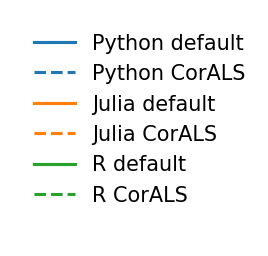

In [26]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D

patchList = []
data_key = Line2D(
    [0], [0], marker="o", color=colors[0], linestyle=styles[0], 
    label="Python default", 
    markersize=0)
patchList.append(data_key)
data_key = Line2D(
    [0], [0], marker="o", color=colors[0], linestyle=styles[1], 
    label=f"Python {method_name}", 
    markersize=0)
patchList.append(data_key)

data_key = Line2D(
    [0], [0], marker="o", color=colors[1], linestyle=styles[0], 
    label="Julia default", 
    markersize=0)
patchList.append(data_key)
data_key = Line2D(
    [0], [0], marker="o", color=colors[1], linestyle=styles[1], 
    label=f"Julia {method_name}", 
    markersize=0)
patchList.append(data_key)

data_key = Line2D(
    [0], [0], marker="o", color=colors[2], linestyle=styles[0], 
    label="R default", 
    markersize=0)
patchList.append(data_key)
data_key = Line2D(
    [0], [0], marker="o", color=colors[2], linestyle=styles[1], 
    label=f"R {method_name}", 
    markersize=0)
patchList.append(data_key)

fig, axes = plt.subplots(1,1, dpi=150, figsize=(2,2))
ax = axes
ax.legend(handles=patchList, loc="upper left", frameon=False)
ax.axis("off")
figures_path = pathlib.Path('../_out/figures')
figures_path.mkdir(parents=True, exist_ok=True)
fig.savefig(figures_path / 'legend.pdf', bbox_inches='tight')

# Main Paper

In [27]:
columns_stats = ["prefix", "language", "algorithm", "data", "memory", "runtime", "context_param", "memory_backend"]
agg_stats = ["median", "mean", "std", "size"]

## Data Table

In [28]:
%%time
import coralsarticle.data.utils
data_path = pathlib.Path("../data/benchmark/")
data = collections.OrderedDict()
for p in data_path.glob("*"):
    if re.match("(pree|preg|canc|sing|large_synthetic)", p.name): 
        df = coralsarticle.data.utils.load_h5(p)
        name = re.search("(.*).h5", p.name).group(1)
        data[name] = df

CPU times: user 1.78 s, sys: 623 ms, total: 2.41 s
Wall time: 2.41 s


In [29]:
def format_data(d, name):
    df_data = pd.DataFrame({
        "Dataset": [name],
        "Features": [d.shape[1]],
        "Samples": [d.shape[0]],
        "Feature/Sample Ratio": [int(np.round(d.shape[1] / d.shape[0]))],
    })
    return df_data

data_df = pd.concat([
    format_data(df, datasets_map[n]) for n, df in data.items()
])
data_df

,Dataset,Features,Samples,Feature/Sample Ratio
0,Preeclampsia,16897,32,528
0,Pregnancy,32211,68,474
0,Cancer (0.25),64672,260,249
0,Cancer (0.50),129345,260,497
0,Cancer (1.00),258690,260,995
0,Single Cell,200000,10,20000
0,Single Cell 2,600000,10,60000
0,Sim,200000,500,400


In [30]:
print(data_df.to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
      Dataset &  Features &  Samples &  Feature/Sample Ratio \\
\midrule
 Preeclampsia &     16897 &       32 &                   528 \\
    Pregnancy &     32211 &       68 &                   474 \\
Cancer (0.25) &     64672 &      260 &                   249 \\
Cancer (0.50) &    129345 &      260 &                   497 \\
Cancer (1.00) &    258690 &      260 &                   995 \\
  Single Cell &    200000 &       10 &                 20000 \\
Single Cell 2 &    600000 &       10 &                 60000 \\
          Sim &    200000 &      500 &                   400 \\
\bottomrule
\end{tabular}



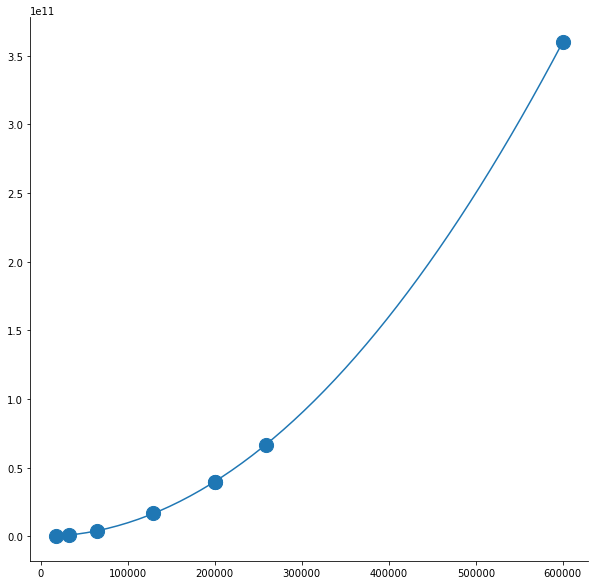

In [32]:
x = data_df.Features
y = x ** 2

xx = np.linspace(min(x),600000)
yy = xx**2


fig, ax = plt.subplots(figsize=(10,10))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.plot(xx, yy)


ax.scatter(x, y, s=200)

In [33]:
# clean-up
del data

## Full Matrix

In [34]:
# everything with non-synthetic data
select = \
    ~(benchmark_experiments["data"].str.startswith("synthetic")) \
    & (benchmark_experiments["context"] == "fast")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    r = benchmark_experiments[select][columns_stats]\
        .groupby(["data", "language", "algorithm", "prefix"])\
        .agg(agg_stats) \
        .sort_index()
    display(r)

memory  \
                                                                                                                           median   
data                                               language algorithm                                 prefix                        
cancer_postprocessed_nonegatives_dropduplicates... julia    cor_cor                                   full_default   32038.969818   
                                                   python   cor_corrcoef                              full_default   32474.320312   
                                                                                                      test           32230.207031   
                                                            cor_corrcoef_nthreads-16                  full_default   32480.830078   
                                                            cor_corrcoef_nthreads-2                   full_default   32470.566406   
                                                            cor_corrcoef_nthreads-32                  full_default   32493.900391   
                                                            cor_corrcoef_nthreads-4                   full_default   32472.771484   
                                                            cor_corrcoef_nthreads-64                  full_default   32516.972656   
                                                            cor_corrcoef_nthreads-8                   full_default   32474.339844   
                                                            cor_matrix_symmetrical                    full_default   32601.357422   
                                                            cor_matrix_symmetrical_nocopy             full_default   32766.785156   
                                                                                                      test           32229.642578   
                                                            cor_matrix_symmetrical_nocopy_nthreads-16 full_default   32480.759766   
                                                            cor_matrix_symmetrical_nocopy_nthreads-2  full_default   32470.750000   
                                                            cor_matrix_symmetrical_nocopy_nthreads-32 full_default   32491.787109   
                                                            cor_matrix_symmetrical_nocopy_nthreads-4  full_default   32473.355469   
                                                            cor_matrix_symmetrical_nocopy_nthreads-64 full_default   32514.583984   
                                                            cor_matrix_symmetrical_nocopy_nthreads-8  full_default   32475.125000   
                                                            cor_matrix_symmetrical_nthreads-16        full_default   32608.914062   
                                                            cor_matrix_symmetrical_nthreads-2         full_default   32597.460938   
                                                            cor_matrix_symmetrical_nthreads-32        full_default   32620.000000   
                                                            cor_matrix_symmetrical_nthreads-4         full_default   32600.451172   
                                                            cor_matrix_symmetrical_nthreads-64        full_default   32648.605469   
                                                                                                      test           32425.082031   
                                                            cor_matrix_symmetrical_nthreads-8         full_default   32603.216797   
                                                   r        cor_cor                                   full_default   31910.435562   
                                                            cor_hiclimr                               full_default   96315.750114   
                                                            cor_rfast                                 full_default   32296.532578   


In [108]:
# select benchmark experiments
b = benchmark_experiments
algorithms_default = [  
    (f"{method_name}",            (b.language == "python") & (b.algorithm == "cor_matrix_symmetrical_nocopy")),
    (f"{method_name} (parallel)", (b.language == "python") & (b.algorithm == "cor_matrix_symmetrical_nthreads-64")),
    ("R",             (b.language == "r")      & (b.algorithm == "cor_cor")),
    ("Julia",         (b.language == "julia")  & (b.algorithm == "cor_cor")),
    ("Python",        (b.language == "python") & (b.algorithm == "cor_corrcoef")),
    ("WGCNA",                         (b.language == "r")      & (b.algorithm == "cor_wgcna")),
    ("coop",                          (b.language == "r")      & (b.algorithm == "cor_coop")),
    ("Rfast",                     (b.language == "r")      & (b.algorithm == "cor_rfast")),
    ("HiClimR",                   (b.language == "r")      & (b.algorithm == "cor_hiclimr")),
]

In [109]:
# general filter
global_select = \
    ~(benchmark_experiments["data"].str.startswith("synthetic")) \
    & (benchmark_experiments["prefix"] == "full_default") \
    & (benchmark_experiments["context"] == "fast") \
#     & (benchmark_experiments["language"] == "python")

In [110]:
# long stats
df, f, l = format_benchmarks(algorithms_default, global_select, statistic="runtime", column_regex=".*")
display(f)

In [111]:
# long stats
df, f, l = format_benchmarks(algorithms_default, global_select, statistic="memory", column_regex=".*")
display(f)

In [112]:
# stats for paper (runtime)
df, f, l = format_benchmarks(algorithms_default, global_select, statistic="runtime", column_regex="median")
display(f)
print(l)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} & \multicolumn{9}{l}{runtime} \\
algorithm &  CorALS & CorALS (parallel) &         R &   Julia & Python &   WGCNA &   coop &  Rfast & HiClimR \\
{} &  median &            median &    median &  median & median &  median & median & median &  median \\
data          &         &                   &           &         &        &         &        &        &         \\
\midrule
Preeclampsia  &     0.9 &               0.4 &       7.9 &     3.7 &    2.0 &     2.8 &    1.7 &    2.3 &    10.2 \\
Pregnancy     &     3.8 &               1.0 &    1:16.5 &    15.1 &    7.7 &    10.1 &    6.9 &    9.0 &  1:28.7 \\
Cancer (0.25) &    33.9 &               5.1 &   19:40.3 &  1:35.6 &   49.2 &  1:37.2 &      - & 1:11.5 & 19:57.0 \\
Cancer (0.50) &  2:20.0 &              19.0 & 1:33:24.5 & 14:43.3 & 3:37.0 & 10:51.3 &      - & 9:11.9 &       - \\
\bottomrule
\end{tabular}



In [113]:
# stats for paper (runtime)
df, f, l = format_benchmarks(algorithms_default, global_select, statistic="memory", column_regex="median")
display(f)
print(l)

\begin{tabular}{lrrrrrrrrr}
\toprule
{} & \multicolumn{9}{l}{memory} \\
algorithm &   CorALS & CorALS (parallel) &        R &    Julia &   Python &    WGCNA &   coop &    Rfast & HiClimR \\
{} &   median &            median &   median &   median &   median &   median & median &   median &  median \\
data          &          &                   &          &          &          &          &        &          &         \\
\midrule
Preeclampsia  &   2.5 Gb &            2.6 Gb &   2.1 Gb &   2.1 Gb &   2.5 Gb &   2.1 Gb & 2.1 Gb &   2.1 Gb &  6.4 Gb \\
Pregnancy     &   8.2 Gb &            8.3 Gb &   7.7 Gb &   7.7 Gb &   8.2 Gb &   7.8 Gb & 7.7 Gb &   7.8 Gb & 23.3 Gb \\
Cancer (0.25) &  32.0 Gb &           31.9 Gb &  31.2 Gb &  31.3 Gb &  31.7 Gb &  31.3 Gb &      - &  31.5 Gb & 94.1 Gb \\
Cancer (0.50) & 125.9 Gb &          126.4 Gb & 124.7 Gb & 124.9 Gb & 125.9 Gb & 125.0 Gb &      - & 125.4 Gb &       - \\
\bottomrule
\end{tabular}



features:      16000 -> memory:       2.10
features:      32000 -> memory:       8.11
features:      64000 -> memory:      31.27
features:     128000 -> memory:     120.59
features:     250000 -> memory:     444.10


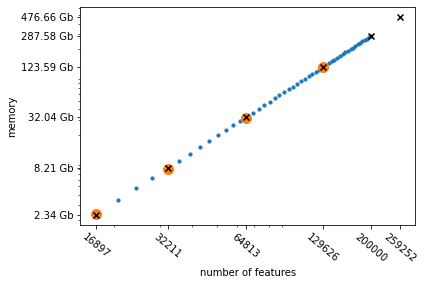

In [ ]:
x = np.array([16897, 32211, 64813, 129626, 200000, 259252])
y = np.array([ 2.38289074,   8.038218,  31.60920241, 125.55584884])
import sklearn.linear_model
lr = sklearn.linear_model.LinearRegression()
lr.fit(np.log(x[:-2].reshape(-1,1)), np.log(y))

yp = np.exp(lr.predict(np.log(x).reshape(-1,1)))


xx = np.linspace(min(x),200000)
yy = np.exp(lr.predict(np.log(xx).reshape(-1,1)))
plt.scatter(xx, yy, s=10)

plt.scatter(x[:-2], y, s=100)
plt.scatter(x, yp, marker="x", c="black")
plt.xscale("log")
plt.yscale("log")

plt.xticks(x, x, rotation=320)
plt.yticks(yp, [f"{yy:.02f} Gb" for yy in yp])
plt.xlabel("number of features")
plt.ylabel("memory")

xx = np.array([16000, 32000, 64000, 128000, 250000])
yy = np.exp(lr.predict(np.log(xx).reshape(-1,1)))
for xxx, yyy in zip(xx, yy):
    print(f"features: {xxx:10d} -> memory: {yyy:10.02f}")

## Top-K

In [45]:
# everything with non-synthetic data

select = \
        ~(benchmark_experiments["data"].str.startswith("synthetic")) \
        & (benchmark_experiments["context"] == "topk")

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    r = benchmark_experiments[select][columns_stats]\
        .groupby(["data", "language", "context_param", "algorithm", "prefix", "memory_backend"])\
        .agg(agg_stats)\
        .sort_index()
    display(r)

memory  \
                                                                                                                                                                  median   
data                                               language context_param algorithm                                          prefix        memory_backend                  
cancer_postprocessed_nonegatives_dropduplicates... julia    0.100         topk_matrix                                        topk_default  default          96050.313721   
                                                   python   0.100         topk_balltree_combined_tree                        topk_default  psutil            4233.835938   
                                                                          topk_balltree_combined_tree_no-dual                topk_default  psutil            4892.583984   
                                                                          topk_balltree_combined_tree_optimized_direct_pa... topk_test     psutil_uss        7134.964844   
                                                                          topk_balltree_combined_tree_optimized_parallel_64  topk_parallel psutil           26841.724609   
                                                                                                                                           psutil_uss        8903.091797   
                                                                                                                             topk_test     psutil_uss        7103.687500   
                                                                          topk_balltree_combined_tree_optimized_parallel_... topk_test     psutil_uss        7092.972656   
                                                                          topk_balltree_combined_tree_optimized_partition... topk_test     psutil_uss        7166.601562   
                                                                          topk_balltree_twice                                topk_default  psutil            8887.431641   
                                                                          topk_batch_balltree_parallel2_64                   topk_test     psutil_uss        6278.910156   
                                                                          topk_batch_balltree_parallel_1                     topk_test     psutil_uss        6520.761719   
                                                                          topk_batch_balltree_parallel_64                    topk_test     psutil_uss        6578.898438   
                                                                          topk_batch_generic                                 topk_test     psutil_uss        4154.519531   
                                                                          topk_batch_matmul_full_disk_threads_parallel_64    topk_test     psutil_uss       18306.437500   
                                                                          topk_batch_matmul_full_parallel_64                 topk_test     psutil_uss      166321.667969   
                                                                          topk_batch_matmul_full_threads_parallel_64         topk_test     psutil_uss      166048.285156   
                                                                          topk_batch_matmul_parallel2_64                     topk_test     psutil_uss        6759.437500   
                                                                          topk_batch_matmul_parallel_64                      topk_test     psutil_uss        9521.113281   
                                                                          topk_batch_matmul_threads_parallel_64              topk_test     psutil_uss        6256.976562   
                                                                          topk_batch_matmul_threshold-0.7_threads_paralle... topk_test     psutil_uss        6005.445312   
                                  

In [46]:
b = benchmark_experiments
algorithms_default = [  
    ("R",             (b.language == "r")      & (b.algorithm == "topk_matrix")),
    ("Julia",         (b.language == "julia")  & (b.algorithm == "topk_matrix")),
    ("Python",        (b.language == "python") & (b.algorithm == "topk_matrix")),
    (f"{method_name}",            (b.language == "python") & (b.algorithm == "topk_balltree_combined_tree")),
]
algorithms_runtime = [
    (f"{method_name} (parallel)", (b.language == "python") & (b.algorithm == "topk_balltree_combined_tree_optimized_parallel_64") & (b.memory_backend == "psutil_uss")),
]
algorithms_memory = [
    (f"{method_name} (parallel)", (b.language == "python") & (b.algorithm == "topk_balltree_combined_tree_optimized_parallel_64") & (b.memory_backend == "psutil_uss")),
]

In [47]:
global_select = \
    ~(benchmark_experiments["data"].str.startswith("synthetic")) \
    & (benchmark_experiments["context"] == "topk") \
    & (benchmark_experiments["context_param"] == 0.1) \
#     & (benchmark_experiments["language"] == "python")

In [48]:
df, f, l = format_benchmarks(algorithms_default + algorithms_runtime, global_select, statistic="runtime", column_regex=".*")
display(f)

In [49]:
df, f, l = format_benchmarks(algorithms_default + algorithms_runtime, global_select, statistic="runtime", column_regex="median")
display(f)
print(l)

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{runtime} \\
algorithm &         R &   Julia &  Python &     CorALS & CorALS (parallel) \\
{} &    median &  median &  median &     median &            median \\
data          &           &         &         &            &                   \\
\midrule
Preeclampsia  &      33.6 &  1:41.9 &  1:11.6 &       14.5 &               2.4 \\
Pregnancy     &    2:09.7 &  8:35.4 &  4:56.1 &     1:49.5 &               5.8 \\
Cancer (0.25) & 7:07:46.0 & 53:19.9 & 22:53.1 &    32:54.4 &              59.6 \\
Cancer (0.50) &         - &       - &       - &  2:10:25.2 &            2:58.4 \\
Cancer (1.00) &         - &       - &       - &  8:42:12.9 &           11:28.5 \\
Single Cell   &         - &       - &       - &    16:10.1 &            1:46.9 \\
Single Cell 2 &         - &       - &       - &  2:09:26.0 &           26:09.2 \\
Sim           &         - &       - &       - & 10:29:36.2 &           22:33.4 \\
\bottomrule
\end{tabular}



In [50]:
df, f, l = format_benchmarks(algorithms_default + algorithms_memory, global_select, statistic="memory", column_regex="median")
display(f)
print(l)

\begin{tabular}{lrrrrr}
\toprule
{} & \multicolumn{5}{l}{memory} \\
algorithm &        R &   Julia &  Python &   CorALS & CorALS (parallel) \\
{} &   median &  median &  median &   median &            median \\
data          &          &         &         &          &                   \\
\midrule
Preeclampsia  &   7.5 Gb &  6.4 Gb &  6.8 Gb &   0.7 Gb &            3.4 Gb \\
Pregnancy     &  27.3 Gb & 23.3 Gb & 23.7 Gb &   1.3 Gb &            4.5 Gb \\
Cancer (0.25) & 157.6 Gb & 93.8 Gb & 94.3 Gb &   4.1 Gb &            8.7 Gb \\
Cancer (0.50) &        - &       - &       - &  14.3 Gb &           21.1 Gb \\
Cancer (1.00) &        - &       - &       - &  53.5 Gb &           65.2 Gb \\
Single Cell   &        - &       - &       - &  33.2 Gb &           38.7 Gb \\
Single Cell 2 &        - &       - &       - & 246.3 Gb &          271.3 Gb \\
Sim           &        - &       - &       - &  30.3 Gb &           35.9 Gb \\
\bottomrule
\end{tabular}



features:      16000 -> memory:       6.25
features:      32000 -> memory:      30.11
features:      64000 -> memory:     145.08
features:     128000 -> memory:     699.00
features:     200000 -> memory:    1923.79
features:     250000 -> memory:    3191.52


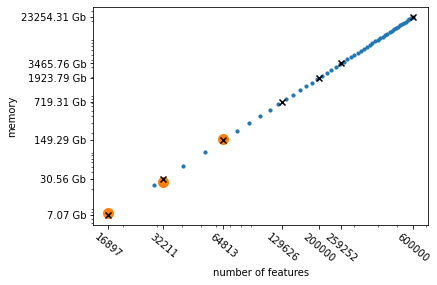

In [53]:
x = np.array([16897, 32211, 64813, 129626, 200000, 259252, 600000])
y = np.array([ 7.5, 27.3, 157.6])
# y = np.array([ 6.4, 23.3, 93.8])
# y = np.array([ 6.8, 23.7, 94.3])

import sklearn.linear_model
lr = sklearn.linear_model.LinearRegression()
lr.fit(np.log(x[:len(y)].reshape(-1,1)), np.log(y))

yp = np.exp(lr.predict(np.log(x).reshape(-1,1)))


xx = np.linspace(min(x),max(x))
yy = np.exp(lr.predict(np.log(xx).reshape(-1,1)))
plt.scatter(xx, yy, s=10)

plt.scatter(x[:len(y)], y, s=100)
plt.scatter(x, yp, marker="x", c="black")
plt.xscale("log")
plt.yscale("log")

plt.xticks(x, x, rotation=320)
plt.yticks(yp, [f"{yy:.02f} Gb" for yy in yp])
plt.xlabel("number of features")
plt.ylabel("memory")

xx = np.array([16000, 32000, 64000, 128000, 200000, 250000])
yy = np.exp(lr.predict(np.log(xx).reshape(-1,1)))
for xxx, yyy in zip(xx, yy):
    print(f"features: {xxx:10d} -> memory: {yyy:10.02f}")

# Supplement


## Euclidean distance vs. correlation 

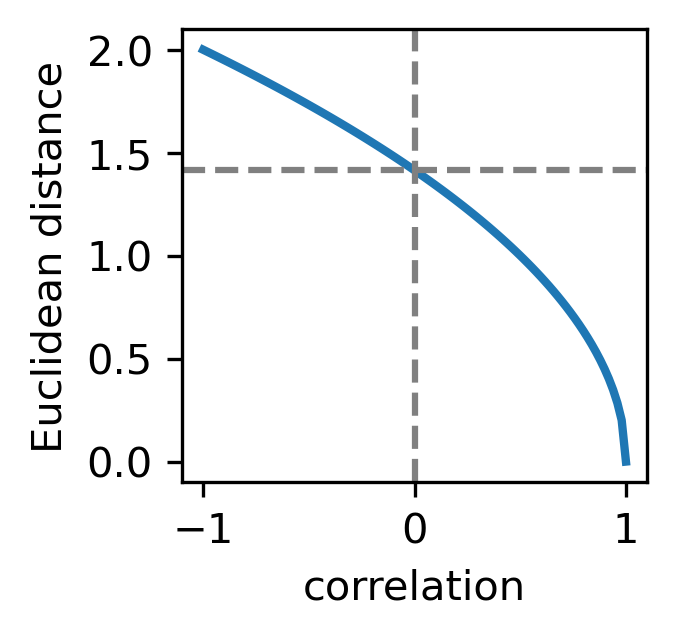

In [54]:
def f(cor):
    return np.sqrt(2 - 2*cor)

fig, ax = plt.subplots(1,1, figsize=(2,2), dpi=300)
c = np.linspace(-1,1,100)
ax.plot(c, f(c), linewidth=2)
ax.set(
    xlabel="correlation",
    ylabel="Euclidean distance")
ax.axhline(np.sqrt(2), color="grey", linestyle="--")
ax.axvline(0, color="grey", linestyle="--")

fig.savefig(out_dir / "dist-vs-cor.pdf", bbox_inches="tight", dpi=300)

## Tree variants

In [55]:
b = benchmark_experiments
algorithms = [  
    ("twice",        (b.language == "python") & (b.algorithm == "topk_balltree_twice")),
    ("no-dual",      (b.language == "python") & (b.algorithm == "topk_balltree_combined_tree_no-dual")),
    ("tree",         (b.language == "python") & (b.algorithm == "topk_balltree_combined_tree")),
]


In [56]:
global_select = \
    ~(benchmark_experiments["data"].str.startswith("synthetic")) \
    & (benchmark_experiments["context"] == "topk") \
    & (benchmark_experiments["context_param"] == 0.1) \
#     & (benchmark_experiments["language"] == "python")

In [57]:
df, f, l = format_benchmarks(algorithms, global_select, statistic="runtime", column_regex="median")
display(f)
print(l)

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{runtime} \\
algorithm &   twice & no-dual &       tree \\
{} &  median &  median &     median \\
data          &         &         &            \\
\midrule
Preeclampsia  &    16.6 &    18.7 &       14.5 \\
Pregnancy     &  1:57.1 &  4:34.1 &     1:49.5 \\
Cancer (0.25) & 33:07.0 & 55:58.8 &    32:54.4 \\
Cancer (0.50) &       - &       - &  2:10:25.2 \\
Cancer (1.00) &       - &       - &  8:42:12.9 \\
Single Cell   &       - &       - &    16:10.1 \\
Single Cell 2 &       - &       - &  2:09:26.0 \\
Sim           &       - &       - & 10:29:36.2 \\
\bottomrule
\end{tabular}



In [58]:
df, f, l = format_benchmarks(algorithms, global_select, statistic="memory", column_regex="median")
display(f)
print(l)

\begin{tabular}{lrrr}
\toprule
{} & \multicolumn{3}{l}{memory} \\
algorithm &  twice & no-dual &     tree \\
{} & median &  median &   median \\
data          &        &         &          \\
\midrule
Preeclampsia  & 1.0 Gb &  0.7 Gb &   0.7 Gb \\
Pregnancy     & 2.4 Gb &  1.3 Gb &   1.3 Gb \\
Cancer (0.25) & 8.7 Gb &  4.8 Gb &   4.1 Gb \\
Cancer (0.50) &      - &       - &  14.3 Gb \\
Cancer (1.00) &      - &       - &  53.5 Gb \\
Single Cell   &      - &       - &  33.2 Gb \\
Single Cell 2 &      - &       - & 246.3 Gb \\
Sim           &      - &       - &  30.3 Gb \\
\bottomrule
\end{tabular}



## Full matrix - Synthetic

In [59]:
benchmark_experiments

,algorithm,repetition,memory,runtime,memory_backend,timestamp,language,prefix,context,context_param,data,n_repeat,file
0,cor_cor,0,32233.144686,91.611162,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
1,cor_cor,1,32038.969818,102.716782,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
2,cor_cor,2,32038.969818,95.984684,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
3,cor_cor,3,32038.969818,94.681850,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
4,cor_cor,4,32038.969818,123.963541,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,topk_batch_balltree_parallel2_64,0,6110.414062,6.482273,psutil_uss,2021-12-06 16:49:47.325718,python,topk_test,topk,0.1,volatile_synthetic_mn_m-5_n-64000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....
0,topk_batch_matmul_parallel2_64,0,5064.820312,12.288486,psutil_uss,2021-12-06 16:49:57.830472,python,topk_test,topk,0.1,volatile_synthetic_mn_m-5_n-64000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....
0,topk_batch_balltree_parallel_64,0,3070.855469,2.191794,psutil_uss,2021-12-06 13:42:22.955511,python,topk_test,topk,0.1,volatile_synthetic_mn_m-68_n-10000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....
0,topk_batch_matmul_parallel_64,0,2904.039062,1.791280,psutil_uss,2021-12-06 13:42:29.091563,python,topk_test,topk,0.1,volatile_synthetic_mn_m-68_n-10000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....


In [60]:
results = benchmark_experiments[
    (benchmark_experiments["data"].str.startswith("synthetic")) 
    & (benchmark_experiments["context"] == "fast") 
#     & (benchmark_experiments["algorithm"].isin(algorithms)) 
].copy()
results.loc[:, "m"] = results["data"].str.extract(".*m-(.*?)_.*").values.flatten().astype(int)
results.loc[:, "n"] = results["data"].str.extract(".*n-(.*?)_").values.flatten().astype(int)

In [61]:
results.algorithm.unique()

array(['cor_cor', 'cor_symmetrical_nocopy2', 'cor_corrcoef',
       'cor_matrix_symmetrical_nocopy', 'cor_symmetrical_nocopy'],
      dtype=object)

cor_cor
cor_symmetrical_nocopy2
cor_cor
cor_symmetrical_nocopy


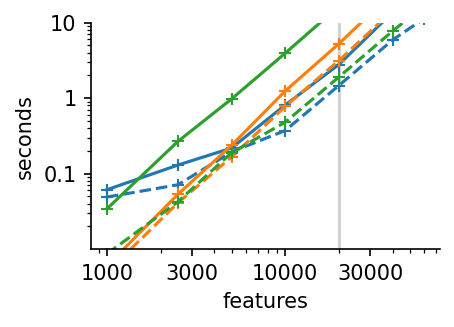

In [62]:
algorithms_python_final = [
    "cor_corrcoef",
#     "cor_matrix_symmetrical", 
    "cor_matrix_symmetrical_nocopy"
]

algorithms_julia_final = [
    "cor_cor", 
#     "cor_symmetrical", 
    "cor_symmetrical_nocopy2"
]

algorithms_r_final = [
    "cor_cor", 
#     "cor_symmetrical", 
    "cor_symmetrical_nocopy"
]

fig, axes = plt.subplots(1,1, figsize=(3,2), dpi=150)
# fig, axes = plt.subplots(1,1, figsize=(10,10), dpi=150)
ax = axes

ax.axvline(20000, linestyle="-", color="lightgrey")

color = colors[0]
styles = ["-", "--", ":", "dashdot", "dashdot","dashdot",]
for i, a in enumerate(algorithms_python_final):
    select = results[(results["language"] == "python") & (results["algorithm"] == a) & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
    ax.plot(select.index, select["runtime"], color=color, linestyle=styles[i], label=a, marker="+")

color = colors[1]
styles = ["-", "--", ":", "dashdot", "dashdot","dashdot",]
for i, a in enumerate(algorithms_julia_final):
    print(a)
    select = results[(results["language"] == "julia") & (results["algorithm"] == a) & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
    ax.plot(select.index, select["runtime"], color=color, linestyle=styles[i], label=a, marker="+")

color = colors[2]
styles = ["-", "--", ":", "dashdot", "dashdot","dashdot",]
for i, a in enumerate(algorithms_r_final):
    print(a)
    select = results[(results["language"] == "r") & (results["algorithm"] == a) & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
    ax.plot(select.index, select["runtime"], color=color, linestyle=styles[i], label=a, marker="+")
    
    
ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim([0,5000])
# ax.set_ylim([0,0.1])
# ax.set_xlim([10000,40000])
# ax.set_ylim([1,10])
# ax.set_xlim([5000,40000])
# ax.set_ylim([0.1,10])

# ax.set_xlim([2000,10000])
ax.set_ylim([0.01,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set(xlabel="features", ylabel="seconds")

ax.set_xticks([1000,3000,10000,30000])
ax.set_xticklabels([1000,3000,10000,30000])

ax.set_yticks([0.1, 1, 10])
ax.set_yticklabels([0.1,1,10])

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# ax.set_xticks(select.index.values[:-1])
# ax.set_xticklabels([str(int(x)) for x in select.index.values / 100][:-1])

fig.savefig(out_dir / "fast_runtime_features.pdf", bbox_inches="tight")

cor_cor
cor_symmetrical_nocopy2
cor_cor
cor_symmetrical_nocopy


<ipython-input-63-2a7641e0cd5a>:54: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim([0,10])


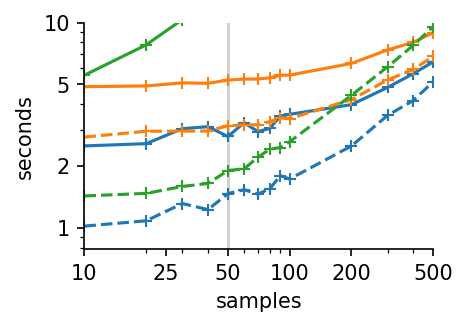

In [63]:
algorithms_python_final = [
    "cor_corrcoef",
#     "cor_matrix_symmetrical", 
    "cor_matrix_symmetrical_nocopy"
]

algorithms_julia_final = [
    "cor_cor", 
#     "cor_symmetrical", 
    "cor_symmetrical_nocopy2"
]

algorithms_r_final = [
    "cor_cor", 
#     "cor_symmetrical", 
    "cor_symmetrical_nocopy"
]

fig, axes = plt.subplots(1,1, figsize=(3,2), dpi=150)
# fig, axes = plt.subplots(1,1, figsize=(10,10), dpi=150)
ax = axes

ax.axvline(50, linestyle="-", color="lightgrey")

color = colors[0]
for i, a in enumerate(algorithms_python_final):
    select = results[(results["language"] == "python") & (results["algorithm"] == a) & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
    ax.plot(select.index, select["runtime"], color=color, linestyle=styles[i], label=a, marker="+")

color = colors[1]
styles = ["-", "--", ":"]
for i, a in enumerate(algorithms_julia_final):
    print(a)
    select = results[(results["language"] == "julia") & (results["algorithm"] == a) & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
    ax.plot(select.index, select["runtime"], color=color, linestyle=styles[i], label=a, marker="+")

color = colors[2]
styles = ["-", "--", ":", "dashdot", (0, (5, 1)),(0, (3, 1, 1, 1, 1, 1))]
for i, a in enumerate(algorithms_r_final):
    print(a)
    select = results[(results["language"] == "r") & (results["algorithm"] == a) & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
    ax.plot(select.index, select["runtime"], color=color, linestyle=styles[i], label=a, marker="+")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim([0,5000])
# ax.set_ylim([0,0.1])
# ax.set_xlim([10000,40000])
# ax.set_ylim([1,10])
# ax.set_xlim([5000,40000])
# ax.set_ylim([0.1,10])

ax.set_xlim([10,500])
ax.set_ylim([0,10])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set(xlabel="samples", ylabel="seconds")

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

ax.set_xticks([10,25, 50,100, 200,500])
ax.set_xticklabels([10,25,50, 100, 200,500])

ax.set_yticks([1,2,5,10])
ax.set_yticklabels([1,2,5,10])

# ax.set_yticks([0.1, 1, 10, 50])
# ax.set_yticklabels([0.1,1,10, 50])

fig.savefig(out_dir / "fast_runtime_samples.pdf", bbox_inches="tight")

## Top-k - Synthetic

In [64]:
algorithms_python = ["topk_matrix", "topk_balltree_combined_tree"]
algorithms_julia = ["topk_matrix", "topk_balltree_nn_combined_tree"]
algorithms_r = ["topk_matrix"]

In [65]:
results = benchmark_experiments[
    (benchmark_experiments["data"].str.startswith("synthetic")) 
    & (benchmark_experiments["context"] == "topk") 
    & (benchmark_experiments["context_param"] == 0.1)
    & (benchmark_experiments["algorithm"].isin(algorithms_python + algorithms_julia)) 
].copy()
results.loc[:, "m"] = results["data"].str.extract(".*m-(.*?)_.*").values.flatten().astype(int)
results.loc[:, "n"] = results["data"].str.extract(".*n-(.*?)_").values.flatten().astype(int)

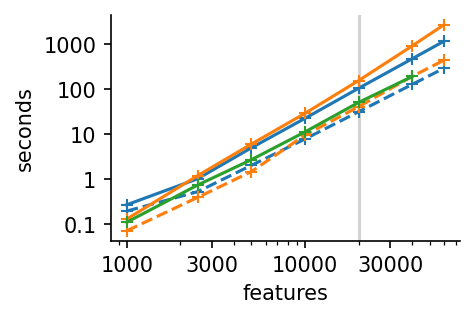

In [66]:
fig, axes = plt.subplots(1,1, figsize=(3,2), dpi=150)
ax = axes

ax.axvline(20000, linestyle="-", color="lightgrey")

select = results[(results["language"] == "python") & (results["algorithm"] == "topk_matrix") & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
ax.plot(select.index, select["runtime"], color=colors[0], label="Python cor", marker="+")

select = results[(results["language"] == "python") & (results["algorithm"] == "topk_balltree_combined_tree") & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
ax.plot(select.index, select["runtime"], color=colors[0], linestyle="--", label="Python LR", marker="+")

select = results[(results["language"] == "julia") & (results["algorithm"] == "topk_matrix") & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
ax.plot(select.index, select["runtime"], color=colors[1], label="Julia cor", marker="+")

select = results[(results["language"] == "julia") & (results["algorithm"] == "topk_balltree_nn_combined_tree") & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
ax.plot(select.index, select["runtime"], color=colors[1], linestyle="--", label="Julia LR", marker="+")

select = results[(results["language"] == "r") & (results["algorithm"] == "topk_matrix") & (results["m"] == 50)][["m", "n", "runtime", "memory"]].groupby("n").median()
ax.plot(select.index, select["runtime"], color=colors[2], label="R cor", marker="+")

ax.set_xscale("log")
ax.set_yscale("log")
# ax.set_xlim([1000, 20000])


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set(xlabel="features", ylabel="seconds")

ax.set_xticks([1000,3000,10000,30000])
ax.set_xticklabels([1000,3000,10000,30000])

ax.set_yticks([0.1, 1, 10,100, 1000])
ax.set_yticklabels([0.1,1,10,100, 1000])

fig.savefig(out_dir / "topk_runtime_features.pdf", bbox_inches="tight")

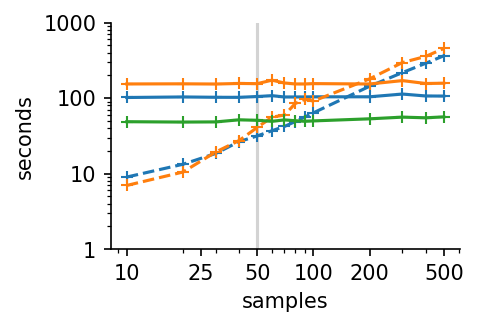

In [67]:
fig, axes = plt.subplots(1,1, figsize=(3,2), dpi=150)
ax = axes

ax.axvline(50, linestyle="-", color="lightgrey")

select = results[(results["language"] == "python") & (results["algorithm"] == "topk_matrix") & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
ax.plot(select.index, select["runtime"], color=colors[0], label="Python cor", marker="+")

select = results[(results["language"] == "python") & (results["algorithm"] == "topk_balltree_combined_tree") & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
ax.plot(select.index, select["runtime"], color=colors[0], linestyle="--", label="Python LR", marker="+")

select = results[(results["language"] == "julia") & (results["algorithm"] == "topk_matrix") & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
ax.plot(select.index, select["runtime"], color=colors[1], label="Julia cor", marker="+")

select = results[(results["language"] == "julia") & (results["algorithm"] == "topk_balltree_nn_combined_tree") & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
ax.plot(select.index, select["runtime"], color=colors[1], linestyle="--", label="Julia LR", marker="+")

select = results[(results["language"] == "r") & (results["algorithm"] == "topk_matrix") & (results["n"] == 20000)][["m", "n", "runtime", "memory"]].groupby("m").median()
ax.plot(select.index, select["runtime"], color=colors[2], label="R cor", marker="+")

ax.set_yscale("log")
ax.set_xscale("log")
# plt.xlim([0,100])

ax.set_xticks([10,25, 50,100, 200,500])
ax.set_xticklabels([10,25,50, 100, 200,500])


ax.set_yticks([1,10,100, 1000])
ax.set_yticklabels([1,10,100, 1000])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
    
ax.set(xlabel="samples", ylabel="seconds")
fig.savefig(out_dir / "topk_runtime_samples.pdf", bbox_inches="tight")

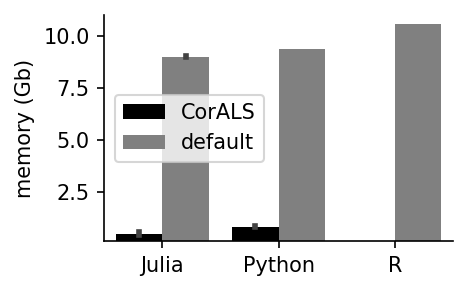

In [68]:
fig, axes = plt.subplots(1,1, figsize=(3,2), dpi=150)
ax = axes

r = results[(results["n"] == 20000) & (results["m"] == 50)]
sns.barplot(
    x=[n.capitalize() for n in r["language"].values], 
    y=r["memory"].values / 1024, 
    hue=[f"{method_name}" if "balltree" in n else "default" for n in r["algorithm"].values], 
    ax=ax, 
    palette=["black", "grey"])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim([0.1,11])

# plt.yscale("log")
ax.set(xlabel=None, ylabel="memory (Gb)")

fig.savefig(out_dir / "topk_memory_50x20000.pdf", bbox_inches="tight")

## Parallelization

In [69]:
results = benchmark_experiments.copy()
results["algorithm_base"] = results.algorithm.str.replace("(_parallel.*)?(_nthreads.*)?", "")
results["algorithm_parallel"] = results.algorithm.str.extract(".*_parallel_([0-9]+).*")
results["algorithm_threads"] = results.algorithm.str.extract(".*_nthreads-([0-9]+).*")
results.loc[results.algorithm_parallel.isna(),"algorithm_parallel"] = 1 
results.loc[results.algorithm_threads.isna(),"algorithm_threads"] = 1 

results["algorithm_parallel"] = results["algorithm_parallel"].astype(int)
results["algorithm_threads"] = results["algorithm_threads"].astype(int)

results

<ipython-input-69-80f8edbbd564>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  results["algorithm_base"] = results.algorithm.str.replace("(_parallel.*)?(_nthreads.*)?", "")


,algorithm,repetition,memory,runtime,memory_backend,timestamp,language,prefix,context,context_param,data,n_repeat,file,algorithm_base,algorithm_parallel,algorithm_threads
0,cor_cor,0,32233.144686,91.611162,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_cor,1,1
1,cor_cor,1,32038.969818,102.716782,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_cor,1,1
2,cor_cor,2,32038.969818,95.984684,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_cor,1,1
3,cor_cor,3,32038.969818,94.681850,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_cor,1,1
4,cor_cor,4,32038.969818,123.963541,default,None,julia,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_cor,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,topk_batch_balltree_parallel2_64,0,6110.414062,6.482273,psutil_uss,2021-12-06 16:49:47.325718,python,topk_test,topk,0.1,volatile_synthetic_mn_m-5_n-64000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....,topk_batch_balltree,1,1
0,topk_batch_matmul_parallel2_64,0,5064.820312,12.288486,psutil_uss,2021-12-06 16:49:57.830472,python,topk_test,topk,0.1,volatile_synthetic_mn_m-5_n-64000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....,topk_batch_matmul,1,1
0,topk_batch_balltree_parallel_64,0,3070.855469,2.191794,psutil_uss,2021-12-06 13:42:22.955511,python,topk_test,topk,0.1,volatile_synthetic_mn_m-68_n-10000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....,topk_batch_balltree,64,1
0,topk_batch_matmul_parallel_64,0,2904.039062,1.791280,psutil_uss,2021-12-06 13:42:29.091563,python,topk_test,topk,0.1,volatile_synthetic_mn_m-68_n-10000_postprocessed,1,benchmark___prefix-topk_test___context-topk-0....,topk_batch_matmul,64,1


### Full matrix

In [70]:
results.data.unique()

array(['cancer_postprocessed_nonegatives_dropduplicates_sample-0.25',
       'cancer_postprocessed_nonegatives_dropduplicates_sample-0.50',
       'preeclampsia_postprocessed_nonegatives_dropduplicates',
       'pregnancy_postprocessed_nonegatives_dropduplicates',
       'synthetic_mn_m-100_n-20000_postprocessed',
       'synthetic_mn_m-10_n-20000_postprocessed',
       'synthetic_mn_m-200_n-20000_postprocessed',
       'synthetic_mn_m-20_n-20000_postprocessed',
       'synthetic_mn_m-300_n-20000_postprocessed',
       'synthetic_mn_m-30_n-20000_postprocessed',
       'synthetic_mn_m-400_n-20000_postprocessed',
       'synthetic_mn_m-40_n-20000_postprocessed',
       'synthetic_mn_m-500_n-20000_postprocessed',
       'synthetic_mn_m-50_n-10000_postprocessed',
       'synthetic_mn_m-50_n-1000_postprocessed',
       'synthetic_mn_m-50_n-20000_postprocessed',
       'synthetic_mn_m-50_n-2500_postprocessed',
       'synthetic_mn_m-50_n-40000_postprocessed',
       'synthetic_mn_m-50_n-5000

In [71]:
algorithms_python

['topk_matrix', 'topk_balltree_combined_tree']

In [72]:
r = results[
    (results.context == "fast") 
    & (results.language == "python") 
    & (results.data.str.contains("cancer_postprocessed_nonegatives_dropduplicates_sample-0.25"))
]
r

,algorithm,repetition,memory,runtime,memory_backend,timestamp,language,prefix,context,context_param,data,n_repeat,file,algorithm_base,algorithm_parallel,algorithm_threads
0,cor_corrcoef,0,32766.062500,52.917707,psutil,2021-05-23 02:55:44.145882,python,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_corrcoef,1,1
1,cor_corrcoef,1,32832.046875,49.189204,psutil,2021-05-23 02:55:44.145882,python,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_corrcoef,1,1
2,cor_corrcoef,2,32832.046875,49.002396,psutil,2021-05-23 02:55:44.145882,python,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_corrcoef,1,1
3,cor_corrcoef,3,32832.046875,49.195871,psutil,2021-05-23 02:55:44.145882,python,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_corrcoef,1,1
4,cor_corrcoef,4,32832.046875,49.129496,psutil,2021-05-23 02:55:44.145882,python,full_default,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-full_default___context-fast...,cor_corrcoef,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,cor_matrix_symmetrical_nthreads-64,5,32425.066406,4.452799,psutil_uss,2021-05-23 02:19:53.773466,python,test,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-test___context-fast___lang-...,cor_matrix_symmetrical,1,64
6,cor_matrix_symmetrical_nthreads-64,6,32425.082031,5.386786,psutil_uss,2021-05-23 02:19:53.773466,python,test,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-test___context-fast___lang-...,cor_matrix_symmetrical,1,64
7,cor_matrix_symmetrical_nthreads-64,7,32425.066406,5.130585,psutil_uss,2021-05-23 02:19:53.773466,python,test,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-test___context-fast___lang-...,cor_matrix_symmetrical,1,64
8,cor_matrix_symmetrical_nthreads-64,8,32425.058594,4.885570,psutil_uss,2021-05-23 02:19:53.773466,python,test,fast,None,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-test___context-fast___lang-...,cor_matrix_symmetrical,1,64


[Text(1, 0, '1'),
 Text(2, 0, '2'),
 Text(4, 0, '4'),
 Text(8, 0, '8'),
 Text(16, 0, '16'),
 Text(32, 0, '32'),
 Text(64, 0, '64')]

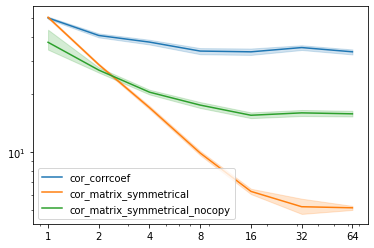

In [73]:
# using copy actually increases runtimes with more cores!
algorithms_python = ["cor_corrcoef", "cor_matrix_symmetrical", "cor_matrix_symmetrical_nocopy"]
# algorithms_python = ["cor_corrcoef", "cor_matrix_symmetrical_nocopy"]
# algorithms_python = ["cor_corrcoef", "cor_matrix_symmetrical"]
# algorithms_python = ["cor_matrix_symmetrical"]
# algorithms_python = ["cor_matrix_symmetrical_nocopy"]
# algorithms_python = ["cor_matrix_symmetrical", "cor_matrix_symmetrical_nocopy"]
algorithms_julia = []

r = results[
    results.algorithm_base.isin(algorithms_python) 
    & (results.context == "fast") 
    & (results.language == "python") 
    & (results.data.str.contains("cancer_postprocessed_nonnegatives_dropduplicates_sample-0.25"))]

r = results[
#     results.algorithm_base.isin(algorithms_python) 
    (results.context == "fast") 
    & (results.language == "python") 
    & (results.data.str.contains("cancer_postprocessed_nonegatives_dropduplicates_sample-0.25"))
]
r

fig, ax = plt.subplots(1,1)
sns.lineplot(x=r.algorithm_threads.values, y=r.runtime.values, hue=r.algorithm_base.values, ax=ax)#, order=[1,2,4,8,16,32,64])
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xticks([1,2,4,8,16,32,64])
ax.set_xticklabels([1,2,4,8,16,32,64])
# plt.yscale("log")
# plt.ylim([5,20])

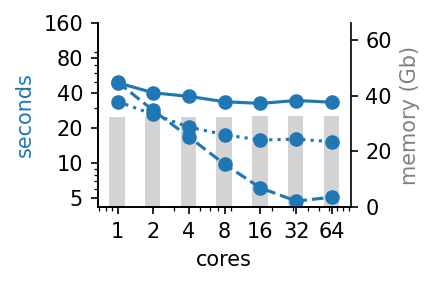

In [74]:
rr = r[(r.algorithm_base == "cor_matrix_symmetrical_nocopy")].groupby(["algorithm_base", "algorithm_threads"]).median().reset_index()
rr2 = r[(r.algorithm_base == "cor_matrix_symmetrical")].groupby(["algorithm_base", "algorithm_threads"]).median().reset_index()
rr3 = r[(r.algorithm_base == "cor_corrcoef")].groupby(["algorithm_base", "algorithm_threads"]).median().reset_index()

order = np.argsort(rr["algorithm_threads"].values)

fig, ax1 = plt.subplots(1,1, figsize=(3,2), dpi=150)

g1, = ax1.plot(
    rr2["algorithm_threads"].values[order], 
    rr2["runtime"].values[order],
    marker="o",
    color=colors[0],
    linestyle="--")

g1, = ax1.plot(
    rr["algorithm_threads"].values[order], 
    rr["runtime"].values[order],
    marker="o",
    color=colors[0],
    linestyle=":")


g1, = ax1.plot(
    rr3["algorithm_threads"].values[order], 
    rr3["runtime"].values[order],
    marker="o",
    color=colors[0],
    linestyle="-")

# ax1.scatter(
#     [64], 
#     [6],
#     marker="o",
#     color="green")

ax1.set_xticks(rr["algorithm_threads"].values)
ax1.set_ylabel("seconds", color=g1.get_color())
ax1.set_xlabel("cores")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.bar(
    rr["algorithm_threads"].values[order], 
    rr["memory"].values[order] / 1000,
    color="lightgrey", 
    width=.3 * rr["algorithm_threads"].values[order],
    align="center")

ax2.set_ylabel("memory (Gb)", color="grey")
ax2.set_ylim([0,66])

ax2.spines['top'].set_visible(False)

ax1.set_zorder(1)
ax1.patch.set_visible(False)

ax1.set(xscale="log", yscale="log")
ax2.set(xscale="log")
ax1.set_xticks(rr["algorithm_threads"].values)
ax1.set_xticklabels(rr["algorithm_threads"].values)

ax1.set_yticks([5, 10,20,40, 80,160])
ax1.set_yticklabels([5, 10,20,40,80,160])

fig.tight_layout()
fig.savefig(
    f"../_out/figures/threads_real-data_fast.pdf", bbox_inches="tight")

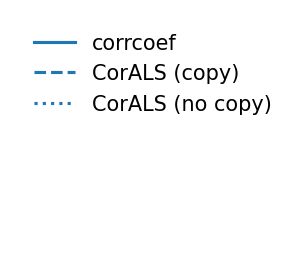

In [75]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D

patchList = []
data_key = Line2D(
    [0], [0], marker="o", color=colors[0], linestyle="-", 
    label="corrcoef", 
    markersize=0)
patchList.append(data_key)

data_key = Line2D(
    [0], [0], marker="o", color=colors[0], linestyle="--", 
    label=f"{method_name} (copy)", 
    markersize=0)
patchList.append(data_key)

data_key = Line2D(
    [0], [0], marker="o", color=colors[0], linestyle=":", 
    label=f"{method_name} (no copy)", 
    markersize=0)
patchList.append(data_key)

fig, axes = plt.subplots(1,1, dpi=150, figsize=(2,2))
ax = axes
ax.legend(handles=patchList, loc="upper left", frameon=False)
ax.axis("off")
fig.savefig('../_out/figures/legend_parallel.pdf', bbox_inches='tight')

### Top-k

In [76]:
r.algorithm_parallel.unique()

array([1])

In [77]:
r = results[
#     results.algorithm_base.isin(algorithms_python) 
#     &
    (results.context == "topk") 
    & (results.language == "python") 
    & (results.context_param == 0.1) 
    & (results.data.str.contains("cancer_postprocessed_nonegatives_dropduplicates_sample-1.00"))
]
r

,algorithm,repetition,memory,runtime,memory_backend,timestamp,language,prefix,context,context_param,data,n_repeat,file,algorithm_base,algorithm_parallel,algorithm_threads
0,topk_balltree_combined_tree,0,54701.570312,31834.268049,psutil,2021-05-26 04:40:23.519271,python,topk_default,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,3,benchmark___prefix-topk_default___context-topk...,topk_balltree_combined_tree,1,1
1,topk_balltree_combined_tree,1,54764.117188,31285.269169,psutil,2021-05-26 04:40:23.519271,python,topk_default,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,3,benchmark___prefix-topk_default___context-topk...,topk_balltree_combined_tree,1,1
2,topk_balltree_combined_tree,2,54794.199219,31332.877907,psutil,2021-05-26 04:40:23.519271,python,topk_default,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,3,benchmark___prefix-topk_default___context-topk...,topk_balltree_combined_tree,1,1
0,topk_balltree_combined_tree_optimized_parallel_16,0,66204.621094,2174.788977,psutil,2021-05-30 11:58:10.347558,python,topk_default,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,3,benchmark___prefix-topk_default___context-topk...,topk_balltree_combined_tree_optimized,16,1
1,topk_balltree_combined_tree_optimized_parallel_16,1,66285.070312,2187.201160,psutil,2021-05-30 11:58:10.347558,python,topk_default,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,3,benchmark___prefix-topk_default___context-topk...,topk_balltree_combined_tree_optimized,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8,topk_balltree_combined_tree_optimized_parallel_64,8,66570.062500,684.037615,psutil_uss,2021-05-27 07:35:51.137471,python,topk_parallel,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-topk_parallel___context-top...,topk_balltree_combined_tree_optimized,64,1
9,topk_balltree_combined_tree_optimized_parallel_64,9,66978.382812,682.607984,psutil_uss,2021-05-27 07:35:51.137471,python,topk_parallel,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,10,benchmark___prefix-topk_parallel___context-top...,topk_balltree_combined_tree_optimized,64,1
0,topk_batch_generic,0,63792.003906,119.526438,psutil_uss,2021-11-29 22:08:24.378545,python,topk_test,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,3,benchmark___prefix-topk_test___context-topk-0....,topk_batch_generic,1,1
1,topk_batch_generic,1,59879.839844,120.343246,psutil_uss,2021-11-29 22:08:24.378545,python,topk_test,topk,0.1,cancer_postprocessed_nonegatives_dropduplicate...,3,benchmark___prefix-topk_test___context-topk-0....,topk_batch_generic,1,1


In [78]:
runtimes = r[r.algorithm_base.str.startswith("topk_balltree_combined_tree_optimized") & (r.prefix == "topk_default") & (r.memory_backend == "psutil")]\
    .groupby(["algorithm_base", "algorithm_parallel"])\
    .agg(["mean", "count"])\
    .reset_index()
display(runtimes)

memory = r[r.algorithm_base.str.startswith("topk_balltree_combined_tree_optimized") & (r.prefix == "topk_default") & (r.memory_backend == "psutil_uss")]\
    .groupby(["algorithm_base", "algorithm_parallel"])\
    .agg(["mean", "count"])\
    .reset_index()
display(memory)

algorithm_base algorithm_parallel        memory  \
                                                                     mean   
0  topk_balltree_combined_tree_optimized                  1  64895.886719   
1  topk_balltree_combined_tree_optimized                  2  65125.416667   
2  topk_balltree_combined_tree_optimized                  4  65253.591146   
3  topk_balltree_combined_tree_optimized                  8  65664.700521   
4  topk_balltree_combined_tree_optimized                 16  66264.404948   
5  topk_balltree_combined_tree_optimized                 32  67868.040365   
6  topk_balltree_combined_tree_optimized                 64  88535.757812   

              runtime       n_repeat       algorithm_threads        
  count          mean count     mean count              mean count  
0     3  31307.091769     3        3     3                 1     3  
1     3  16064.340106     3        3     3                 1     3  
2     3   8239.343672     3        3     3                 1     3  
3     3   4200.483926     3        3     3                 1     3  
4     3   2179.625261     3        3     3                 1     3  
5     3   1166.447781     3        3     3                 1     3  
6     3    735.349975     3        3     3                 1     3

algorithm_base algorithm_parallel        memory  \
                                                                     mean   
0  topk_balltree_combined_tree_optimized                  1  54859.867188   
1  topk_balltree_combined_tree_optimized                  2  63564.583333   
2  topk_balltree_combined_tree_optimized                  4  63662.578125   
3  topk_balltree_combined_tree_optimized                  8  63891.916667   
4  topk_balltree_combined_tree_optimized                 16  64232.305990   
5  topk_balltree_combined_tree_optimized                 32  65249.454427   
6  topk_balltree_combined_tree_optimized                 64  66889.171875   

              runtime       n_repeat       algorithm_threads        
  count          mean count     mean count              mean count  
0     3  49327.475162     3        3     3                 1     3  
1     3  16399.296838     3        3     3                 1     3  
2     3   8252.195677     3        3     3                 1     3  
3     3   4214.726192     3        3     3                 1     3  
4     3   2189.777068     3        3     3                 1     3  
5     3   1170.805097     3        3     3                 1     3  
6     3    693.868312     3        3     3                 1     3

In [79]:
aggregate = runtimes.copy()
aggregate.loc[aggregate.algorithm_base.str.startswith("topk_balltree_combined_tree_optimized").values, ("memory", "mean")] = memory.memory["mean"].values
aggregate

algorithm_base algorithm_parallel        memory  \
                                                                     mean   
0  topk_balltree_combined_tree_optimized                  1  54859.867188   
1  topk_balltree_combined_tree_optimized                  2  63564.583333   
2  topk_balltree_combined_tree_optimized                  4  63662.578125   
3  topk_balltree_combined_tree_optimized                  8  63891.916667   
4  topk_balltree_combined_tree_optimized                 16  64232.305990   
5  topk_balltree_combined_tree_optimized                 32  65249.454427   
6  topk_balltree_combined_tree_optimized                 64  66889.171875   

              runtime       n_repeat       algorithm_threads        
  count          mean count     mean count              mean count  
0     3  31307.091769     3        3     3                 1     3  
1     3  16064.340106     3        3     3                 1     3  
2     3   8239.343672     3        3     3                 1     3  
3     3   4200.483926     3        3     3                 1     3  
4     3   2179.625261     3        3     3                 1     3  
5     3   1166.447781     3        3     3                 1     3  
6     3    735.349975     3        3     3                 1     3

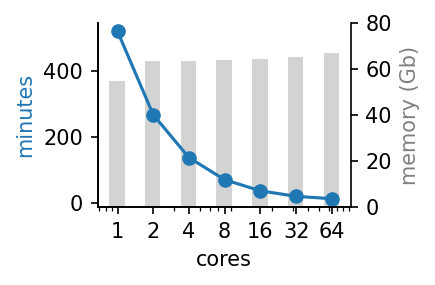

In [80]:
rr = aggregate

order = np.argsort(rr["algorithm_parallel"].values)

fig, ax1 = plt.subplots(1,1, figsize=(3,2), dpi=150)

g1, = ax1.plot(
    rr["algorithm_parallel"].values[order], 
    rr["runtime"]["mean"].values[order] / 60,
    marker="o")

ax1.set_xticks(rr["algorithm_parallel"].values)
ax1.set_ylabel("minutes", color=g1.get_color())
ax1.set_xlabel("cores")

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

ax2 = ax1.twinx()
ax2.bar(
    rr["algorithm_parallel"].values[order], 
    rr["memory"]["mean"].values[order] / 1000,
    color="lightgrey", 
    width=.3 * rr["algorithm_parallel"].values[order],
    align="center")

ax2.set_ylabel("memory (Gb)", color="grey")
ax2.set_ylim([0,80])

ax2.spines['top'].set_visible(False)

ax1.set_zorder(1)
ax1.patch.set_visible(False)

# ax1.set(xscale="log", yscale="log")
ax2.set(xscale="log")

ax1.set_xticks(rr["algorithm_parallel"].values)
ax1.set_xticklabels(rr["algorithm_parallel"].values)

# ax1.set_yticks(rr["algorithm_parallel"].values)
# ax1.set_yticklabels(rr["algorithm_parallel"].values)


fig.tight_layout()
fig.savefig(out_dir / "threads_real-data_topk.pdf", bbox_inches="tight")

## Comprehensive comparison with other libraries

Also see `scripts` for small scale experiments.

## Accuracy

### Plot

<ipython-input-115-0239b3be4216>:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  ("preeclampsia", accuracy_experiments.loc[("preeclampsia_negative_dropduplicates", "topk", 1, "unknown")]),
<ipython-input-115-0239b3be4216>:3: PerformanceWarning: indexing past lexsort depth may impact performance.
  ("pregnancy", accuracy_experiments.loc[("pregnancy_negative_dropduplicates", "topk", 1, "unknown")]),
<ipython-input-115-0239b3be4216>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  ("cancer", accuracy_experiments.loc[("cancer_negative_dropduplicates_sample-0.25", "topk", 1, "unknown")])


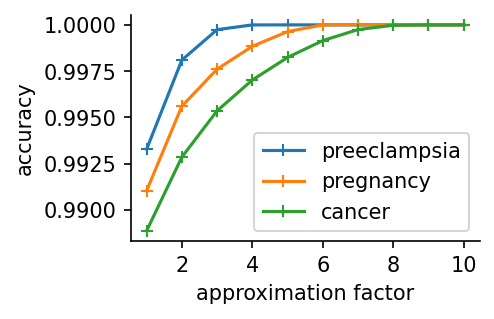

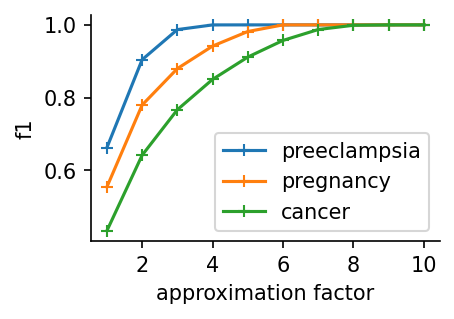

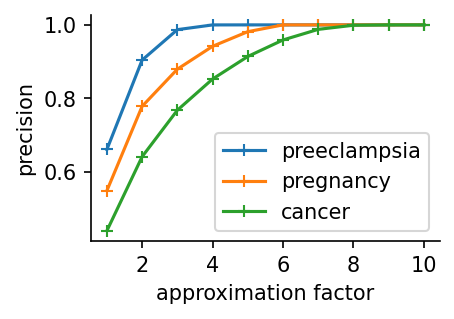

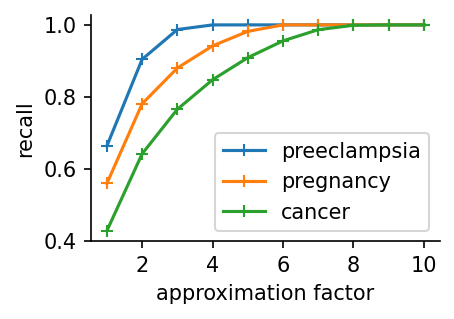

In [115]:
accuracies = [
    ("preeclampsia", accuracy_experiments.loc[("preeclampsia_negative_dropduplicates", "topk", 1, "unknown")]),
    ("pregnancy", accuracy_experiments.loc[("pregnancy_negative_dropduplicates", "topk", 1, "unknown")]),
    ("cancer", accuracy_experiments.loc[("cancer_negative_dropduplicates_sample-0.25", "topk", 1, "unknown")])
]


for c in accuracies[0][1].columns:
    
    fig, axes = plt.subplots(1,1, figsize=(3,2), dpi=150)
    ax = axes
        
    for n, accuracy in accuracies: 
#         display(accuracy)
        ax.plot(accuracy.reset_index()["approximation_factor"], accuracy[c].values, label=n, marker="+")
        
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set(xlabel="approximation factor", ylabel=c)
    ax.legend()
    fig.savefig(
        f"../_out/figures/accuracy_real-data_topk-1percent_{c}.pdf", bbox_inches="tight")